# Guerlédan 2023/10: ctd

In [2]:
import os
from glob import glob

import pandas as pd
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt

import hvplot.pandas # noqa

import pynsitu as pin

## load data

In [10]:
root_path = "/Users/aponte/Current_Projects/ensta/guerledan/202310/data_hydro/"

data_files = sorted(glob(os.path.join(root_path, "*.aml")))
#data_files

In [11]:
Columns = [
    "date", "time", "battery", 
    "turbidity", "ADC", 
    "wipe", "ADC", 
    "pressure", "ADC", 
    "chloro-blue", "ADC", 
    "conductivity" ,"ADC", 
    "temperature", "ADC", 
    "salinity", "density", "calcSV", "depth",
]
Units = [
    "yyyy-mm-dd", "hh:mm:ss.ss", "V", 
    "NTU", "2sComp", 
    "wipe", "wipe", 
    "dBar", "2sComp", 
    "ug/L", "2sComp", 
    "mS/cm", "none", 
    "C", "none", 
    "PSU", "kg/cm3", "m/s", "m",
]

def read_aml_file(file):

    with open(file) as f:
        lines = f.readlines()

    i=1
    line = lines[0]
    while "[MeasurementData]" not in line:
        line = lines[i].replace("\n", "")
        if 'GPSLatitude' in line:
            lat = float(line.split("=")[1])
        if 'GPSLongitude' in line:
            lon = float(line.split("=")[1])
        i+=1
    
    df = pd.DataFrame([parse_line(line) for line in lines[i:]])
    df = df.loc[df.salinity>0]
    df["latitude"] = lat
    df["longitude"] = lon

    return df

def parse_line(line):
    ls = line.replace("\n","").split(",")
    try:
        d = {**{"time": pd.Timestamp(ls[0]+" "+ls[1])}, 
             **{key: float(value) for key, value in zip(Columns[2:], ls[2:])},
            }
    except:
        print(line)
    #print(line)
    return d
    
def load_descent(file):

    df = read_aml_file(file)

    # select descent
    df = df.loc[
        (df["depth"] < df["depth"].max()-.5)
        & (df["depth"] > .5) 
        & (df.index < df["depth"].idxmax()) 
    ]

    # add descent speed
    dt = df.time.diff() / pd.Timedelta("1s")
    df["speed"] = df.depth.diff()/ dt
    
    return df

In [12]:
D = [load_descent(f) for f in data_files]
# filter out empty dataframes
D = [df for df in D if df.size>0]

# summarize station data in a dataframe
stations = pd.DataFrame([dict(time=df.time.iloc[0], 
                              longitude=df.longitude.iloc[0], latitude=df.latitude.iloc[0],
                              temperature_max=df.temperature.max(),
                             ) for df in D])

## plot

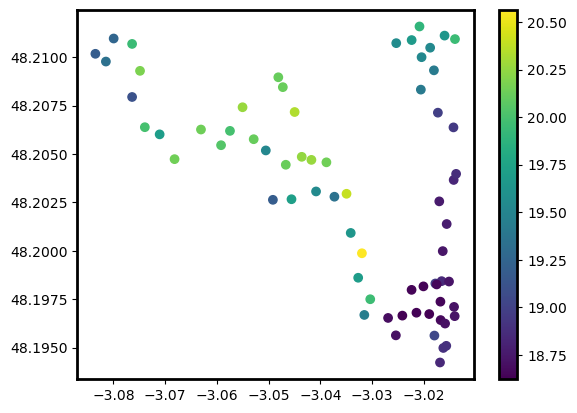

In [15]:
fig, ax = plt.subplots(1,1)
h = ax.scatter(stations.longitude, stations.latitude, c=stations.temperature_max)
fig.colorbar(h)

Text(0.5, 1.0, 'chloro-blue')

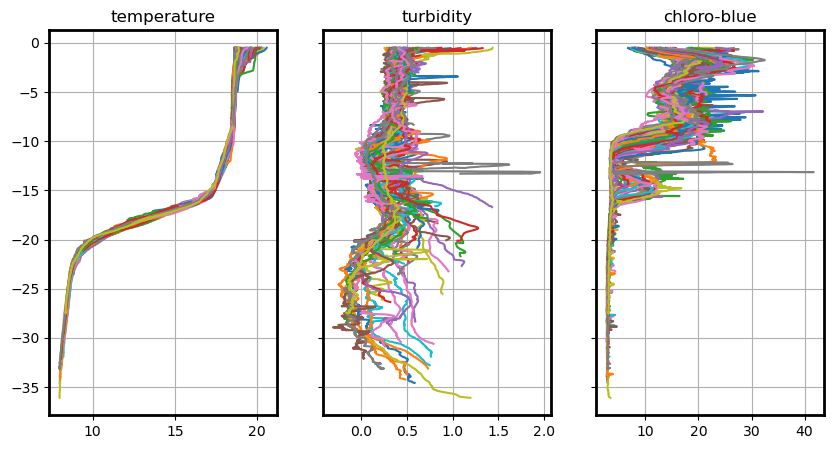

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(10,5), sharey=True)

ax = axes[0]
off = 0
for i, df in enumerate(D):
    ax.plot(df.temperature+i*off, -df.depth)
ax.grid()
ax.set_title("temperature")
    
ax = axes[1]
off = 0
for i, df in enumerate(D):
    ax.plot(np.log10(df.turbidity+i*off), -df.depth)
ax.grid()
ax.set_title("turbidity")
    
    
ax = axes[2]
off = 0
for i, df in enumerate(D):
    ax.plot(df["chloro-blue"]+i*off, -df.depth)
ax.grid()
ax.set_title("chloro-blue")


In [1]:
#df["depth"].hvplot() * dfd["depth"].hvplot()

<Axes: ylabel='Frequency'>

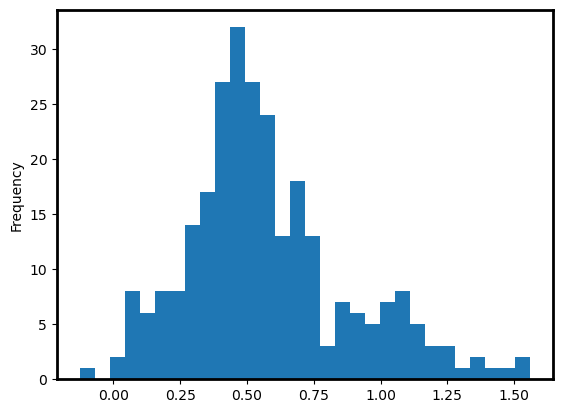

In [18]:
df["speed"].plot.hist(bins=30)